In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import Model
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

display(HTML("<style> .container{width:90% !important;}</style>"))

mnist = tf.keras.datasets.mnist

tf.keras.backend.set_floatx('float64')

#값 0 <= x <= 1 사이로 조절
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#채널 차원 추가
#마지막 채널은 컬러 채널로, 이미지가 흑백이기 때문에 1
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

#train_dataset , test_dataset
#배치 형태로 저장됨 - BatchDataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


In [3]:
########### Keras 모델 ###########
class CNN (Model):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
    self.pool = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')
    self.flatten = tf.keras.layers.Flatten()
    #self.layer1 = tf.keras.layers.Dense(1024, activation='relu')
    #self.layer2 = tf.keras.layers.Dense(512, activation='relu')
    self.layer3 = tf.keras.layers.Dense(256, activation='relu')
    self.layer4 = tf.keras.layers.Dense(128, activation='relu')
    self.out = tf.keras.layers.Dense(10, activation='softmax')
    
  def call(self, x):
    x = self.conv(x)
    x = self.pool(x)
    x = self.flatten(x)
    #x = self.layer1(x)
    #x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return self.out(x)

model = CNN()

In [4]:
########### 기타 변수 설정 ###########
Epochs = 10 #Total Epoch - 총 학습 횟수
L = 0.001 #Learninng rate
optimizer = tf.keras.optimizers.Adam(L)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

#측정 항목 (metrics) 설정
train_loss = tf.metrics.Mean(name = 'train_loss')
train_accuracy = tf.metrics.SparseCategoricalAccuracy()
test_loss = tf.metrics.Mean(name = 'test_loss')
test_accuracy = tf.metrics.SparseCategoricalAccuracy()

In [5]:
########### 학습 ###########
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        t_predict = model(x)
        t_loss = loss(y, t_predict)
    gradients = tape.gradient(t_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(t_loss)
    train_accuracy(y, t_predict)

@tf.function
def test(x,y):
    t_predict = model(x)
    t_loss = loss(y, t_predict)
    
    test_loss(t_loss)
    test_accuracy(y, t_predict)
    
for e in range(Epochs):
    for x, y in train_ds:
        train(x, y)
    for x, y in test_ds:
        test(x, y)
    
    template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
    print (template.format(e+1,train_loss.result(), train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))
print("Train & Test Finished")


에포크: 1, 손실: 0.1779858351048703, 정확도: 94.80499999999999, 테스트 손실: 0.07200008208784216, 테스트 정확도: 97.64
에포크: 2, 손실: 0.11702744813965789, 정확도: 96.5375, 테스트 손실: 0.06218269266544364, 테스트 정확도: 97.97
에포크: 3, 손실: 0.08952168351912405, 정확도: 97.32388888888889, 테스트 손실: 0.06069195939856693, 테스트 정확도: 98.05
에포크: 4, 손실: 0.07301522351085926, 정확도: 97.80291666666666, 테스트 손실: 0.05769639138968098, 테스트 정확도: 98.1475
에포크: 5, 손실: 0.06160966203975841, 정확도: 98.13933333333334, 테스트 손실: 0.05681927945301454, 테스트 정확도: 98.21
에포크: 6, 손실: 0.05341762363924418, 정확도: 98.38416666666666, 테스트 손실: 0.05536414955226516, 테스트 정확도: 98.27666666666667
에포크: 7, 손실: 0.04704616410365339, 정확도: 98.57380952380952, 테스트 손실: 0.055075905174675706, 테스트 정확도: 98.31857142857143
에포크: 8, 손실: 0.042396612592135625, 정확도: 98.70979166666667, 테스트 손실: 0.056258083924056214, 테스트 정확도: 98.31625000000001
에포크: 9, 손실: 0.03852001944027077, 정확도: 98.82425925925926, 테스트 손실: 0.057187751199792275, 테스트 정확도: 98.32333333333332
에포크: 10, 손실: 0.03520744317879621, 정확도: 98.924666

In [6]:
path = "C:\\Users\\jiyoo\\Documents\\jupyter\\123"
imagePaths = [os.path.join(path,file_name) for file_name in os.listdir(path)]

label = [[1], [2], [3], [4], [5], [6], [7], [8], [9]]
prd_label = np.array(label) #label이 들어있는 배열
prd_array = np.empty((0, 1, 10)) #예측 결과 tensor가 들어있는 배열
img_arr = np.empty((0, 1, 28, 28, 1)) #예측용 이미지 저장 배열

for image in imagePaths: #이미지를 배열로 변환하여 저장
    img = tf.compat.v1.read_file(image)
    img_array = tf.image.decode_png(img, channels=1)
    
    img_array_np = np.array(img_array) / 255.0
    img_array_np = np.expand_dims(img_array_np, axis = 0)

    prd_array = np.r_[prd_array, [model(img_array_np)]]
    img_arr = np.r_[img_arr, [img_array_np]]
    
print(prd_array.shape)
print(img_arr.shape)
print(prd_label.shape)

(9, 1, 10)
(9, 1, 28, 28, 1)
(9, 1)


In [7]:
def plot_image(i, prd_array, prd_label, img_arr):
    prediction, label, img = prd_array[i][0], prd_label[i], img_arr[i].reshape(28, 28)
    plt.grid(False)
    plt.xticks([])
    plt.imshow(img, cmap = 'gray')
    predicted = np.argmax(prediction)
    if predicted == label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(label,100*np.max(prediction), np.argmax(prediction)))
    
def plot_value_array(i, prd_array, prd_label):
    prediction, label = prd_array[i][0], prd_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), prediction, color="#777777")
    plt.ylim([0, 1])
    predicted = np.argmax(prediction)
    
    thisplot[predicted].set_color('red')
    thisplot[np.array(label[0])].set_color('blue')

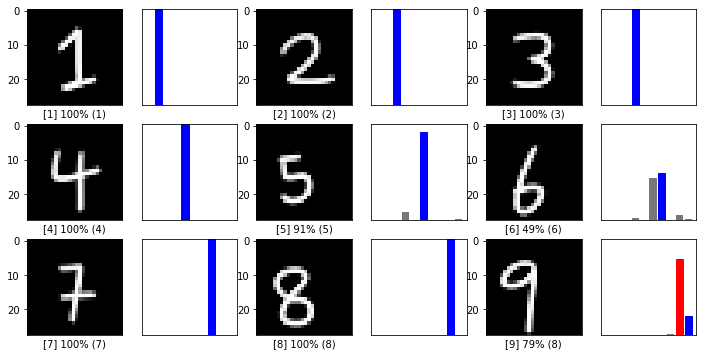

In [8]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(9):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, prd_array, prd_label, img_arr)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, prd_array, prd_label)
plt.show()
